<a href="https://colab.research.google.com/github/reshalfahsi/point-cloud-segmentation/blob/master/Point_Cloud_Segmentation_Using_PointNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Point Cloud Segmentation Using PointNet**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 32.1 MB/s eta 0:00:00


### **Import**

In [2]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import MulticlassJaccardIndex

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torch.autograd import Variable
from torchvision.datasets.utils import download_url

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from glob import glob

import os
import cv2
import math
import copy
import json
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
BATCH_SIZE     = 16
EPOCH          = 256
NUM_SAMPLE_POINTS = 2048

In [4]:
REDUCE_LR_FACTOR        = 1/2
REDUCE_LR_STEP          = 1/4
EARLY_STOPPING_PATIENCE = 1/8
LEARNING_RATE           = 1/512

In [5]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

DATASET = "Motorbike"

In [6]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1958278634


## **Dataset**

### **Download and Prepare**

In [7]:
download_url(
    url="https://git.io/JiY4i",
    root="experiment/dataset",
    filename="shapenet.zip",
)

100%|██████████| 1078925405/1078925405 [00:03<00:00, 279362463.40it/s]


In [8]:
!unzip experiment/dataset/shapenet.zip -d experiment/dataset
!rm experiment/dataset/shapenet.zip

Streaming output truncated to the last 5000 lines.
  inflating: experiment/dataset/PartAnnotation/03467517/points/c73e40b1c97e24d8a1f251d725bedef2.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/15847850d132460f1fb05d58f51ec4fa.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/7eac9185f94e7be35fd682b25025f90d.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/ec1149cc44edf89a6909632a947fc19b.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/601e01d49a1daf2c79f4a19b034b33f.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/54eedf9608f598d5329909d772c2a884.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/16916a50a064304bf6ed0b697979412e.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/f11881e9363c00f6352e5d4d2615db5b.pts  
  inflating: experiment/dataset/PartAnnotation/03467517/points/2adbf6c3f8f2d9ca7fe36b1f0a632ed8.pts  
  inflating: experiment/dataset/

### **ShapeNet Dataset**

In [9]:
class ShapeNetDataset(data.Dataset):
    flag = DATASET
    root = "experiment/dataset"
    split = None
    train_val_ratio = 0.1
    train_test_ratio = 0.2

    def __init__(self):

        with open(f"{self.root}/PartAnnotation/metadata.json") as json_file:
            self.metadata = json.load(json_file)

        self.points_dir = (
            f"{self.root}/PartAnnotation/{self.metadata[self.flag]['directory']}/points"
        )
        self.labels_dir = (
            f"{self.root}/PartAnnotation/{self.metadata[self.flag]['directory']}/points_label"
        )

        self.labels = self.metadata[self.flag]["lables"]

    def __call__(self, split):
        assert split is not None and split in [
            "train",
            "val",
            "test",
            "inference",
        ], "Please define the dataset split: 'train', 'val', 'test', or 'inference'"

        self.split = split

        print(f"Dataset split: {self.split}")

        point_clouds, inference_point_clouds, point_cloud_labels = (
            list(),
            list(),
            list(),
        )

        points_files = glob(os.path.join(self.points_dir, "*.pts"))
        for point_file in points_files:
            point_cloud = np.loadtxt(point_file)
            if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
                continue

            # Get the file-id of the current point cloud for parsing its
            # labels.
            file_id = point_file.split("/")[-1].split(".")[0]
            label_data, num_point_labels = dict(), 0
            for label in self.labels:
                label_file = os.path.join(self.labels_dir, label, file_id + ".seg")
                if os.path.exists(label_file):
                    label_data[label] = np.loadtxt(label_file).astype("float32")
                    num_point_labels = len(label_data[label])

            # Point clouds having labels will be our training samples.
            try:
                label_map = ["none"] * num_point_labels
                for label in self.labels:
                    for idx, data in enumerate(label_data[label]):
                        label_map[idx] = label if data == 1 else label_map[idx]
                label_data = [
                    self.labels.index(label) if label != "none" else len(self.labels)
                    for label in label_map
                ]

                point_clouds.append(point_cloud)
                point_cloud_labels.append(label_data)
            except KeyError:
                inference_point_clouds.append(point_cloud)

        def preprocessing(
            current_point_cloud,
            current_label_cloud=None,
        ):
            num_points = len(current_point_cloud)
            sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)

            num_points = len(current_point_cloud)

            # Randomly sampling respective indices.
            sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)

            # Sampling points corresponding to sampled indices.
            sampled_point_cloud = np.array(
                [current_point_cloud[i] for i in sampled_indices]
            )

            if current_label_cloud is not None:
                # Sampling corresponding one-hot encoded labels.
                sampled_label_cloud = np.array(
                    [current_label_cloud[i] for i in sampled_indices]
                )

            # Normalizing sampled point cloud.
            norm_point_cloud = sampled_point_cloud - np.mean(
                sampled_point_cloud, axis=0
            )
            norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))

            if current_label_cloud is not None:
                return norm_point_cloud, sampled_label_cloud

            return norm_point_cloud

        if self.split == "inference":
            del point_clouds, point_cloud_labels

            for index in range(len(inference_point_clouds)):
                current_point_cloud = inference_point_clouds[index]
                inference_point_clouds[index] = preprocessing(current_point_cloud)

            self.point_clouds = inference_point_clouds
            self.inference_index = random.randint(0, len(self.point_clouds) - 1)

            print(f"Size: {len(self.point_clouds)}")

            return self
        else:
            del inference_point_clouds

        for index in range(len(point_clouds)):
            current_point_cloud = point_clouds[index]
            current_label_cloud = point_cloud_labels[index]

            point_clouds[index], point_cloud_labels[index] = preprocessing(
                current_point_cloud,
                current_label_cloud,
            )

        if self.split == "train":
            start = 0
            end = int((1 - 0.2) * (1 - 0.1) * len(point_clouds))
        elif self.split == "val":
            start = int((1 - 0.2) * (1 - 0.1) * len(point_clouds))
            end = int((1 - 0.2) * len(point_clouds))
        elif self.split == "test":
            start = int((1 - 0.2) * len(point_clouds))
            end = len(point_clouds)

        self.point_clouds = point_clouds[start:end]
        self.point_cloud_labels = point_cloud_labels[start:end]

        print(f"Size: {len(self.point_clouds)}")

        return self

    @property
    def inference_point_cloud(self):
        assert (
            self.split == "inference"
        ), f"Cannot access ``inference_image`` invalid split, expected 'inference' got {self.split}"
        return self.point_clouds[self.inference_index].astype("float32")

    def __len__(self):
        if self.split == "inference":
            return 1
        return len(self.point_clouds)

    def __getitem__(self, idx):
        if self.split != "inference":
            pcloud = torch.tensor(self.point_clouds[idx].astype("float32")).permute(1, 0)
            pcloud = pcloud + 0.001 * torch.rand(pcloud.size(0), pcloud.size(1))
            plabel = torch.tensor(self.point_cloud_labels[idx].astype("int64"))

            return pcloud, plabel

        idx = self.inference_index
        pcloud = torch.tensor(self.point_clouds[idx].astype("float32")).permute(1, 0)
        pcloud = pcloud + 0.001 * torch.rand(pcloud.size(0), pcloud.size(1))

        return pcloud

### **Load**

In [10]:
ShapeNetDataset = ShapeNetDataset()

## **Model**

### **Utils**

In [11]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **PointNet**

In [12]:
def orthogonal_regularizer(x):
    d = x.size()[1]
    batchsize = x.size()[0]
    I = torch.eye(d)[None, :, :]
    if x.is_cuda:
        I = I.cuda()
    loss = torch.mean(
        torch.norm(
            torch.bmm(x, x.transpose(2,1)) - I, dim=(1,2)
        )
    )
    return loss

In [13]:
# Define the TNet (Transformation Network)
class TNet(nn.Module):
    def __init__(self, num_features):
        super(TNet, self).__init__()

        self.conv1 = torch.nn.Conv1d(num_features, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_features * num_features)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = num_features

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(
            torch.from_numpy(
                np.eye(self.k).flatten().astype(np.float32)
            )
        ).view(1, self.k * self.k).repeat(batchsize,1)

        if x.is_cuda:
            iden = iden.cuda()

        x = x + iden
        x = x.view(-1, self.k, self.k)

        return x

In [14]:
# Define the PointNet architecture
class PointNet(nn.Module):
    def __init__(self, in_features, num_classes):
        super(PointNet, self).__init__()

        self.k = num_classes

        self.stn = TNet(in_features)
        self.conv1 = torch.nn.Conv1d(in_features, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fstn = TNet(64)

        self.conv4 = torch.nn.Conv1d(1088, 512, 1)
        self.conv5 = torch.nn.Conv1d(512, 256, 1)
        self.conv6 = torch.nn.Conv1d(256, 128, 1)
        self.conv7 = torch.nn.Conv1d(128, self.k, 1)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]

        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        trans_feat = self.fstn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans_feat)
        x = x.transpose(2,1)

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]

        x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
        x = torch.cat([x, pointfeat], 1)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.conv7(x)

        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1, self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)

        if self.training:
            return x, trans, trans_feat

        return x

In [15]:
MODEL = PointNet
MODEL_NAME = MODEL.__name__
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR,f"{MODEL_NAME}_best.ckpt")

### **Wrapper**

In [16]:
class ModelWrapper(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.num_classes = len(ShapeNetDataset.labels) + 1

        self.arch = MODEL(3, self.num_classes)

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.automatic_optimization = False

        self.train_iou_compute = MulticlassJaccardIndex(
            num_classes=self.num_classes,
            ignore_index=self.num_classes - 1,
        )
        self.val_iou_compute = MulticlassJaccardIndex(
            num_classes=self.num_classes,
            ignore_index=self.num_classes - 1,
        )
        self.test_iou_compute = MulticlassJaccardIndex(
            num_classes=self.num_classes,
            ignore_index=self.num_classes - 1,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_iou_list = list()
        self.val_iou_list = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_iou_recorder = AvgMeter()
        self.val_iou_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, input_transform, feature_transform = self(x)

        loss = (
            F.nll_loss(
                y_hat.view(-1, self.num_classes),
                y.view(-1),
                ignore_index=self.num_classes-1,
            )
            + 0.001 * orthogonal_regularizer(input_transform)
            + 0.001 * orthogonal_regularizer(feature_transform)
        )

        self.train_iou_compute.update(
            y_hat.view(-1, self.num_classes),
            y.view(-1),
        )
        iou = self.train_iou_compute.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_iou", iou, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_iou_recorder.update(iou)

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_iou_list.append(self.train_iou_recorder.show().data.cpu().numpy())
        self.train_iou_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)

        loss = F.nll_loss(
            y_hat.view(-1, self.num_classes),
            y.view(-1),
            ignore_index=self.num_classes-1,
        )

        if self.sanity_check_counter == 0:
            self.val_iou_compute.update(
                y_hat.view(-1, self.num_classes),
                y.view(-1),
            )
            iou = self.val_iou_compute.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_iou", iou, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_iou_recorder.update(iou)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
            self.val_loss_recorder = AvgMeter()
            iou = self.val_iou_recorder.show().data.cpu().numpy()
            sch = self.lr_schedulers()

            sch.step()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                print(
                    f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_} - Epoch: {self.current_epoch}"
                )

            self.val_iou_list.append(iou)
            self.val_iou_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = F.nll_loss(
            y_hat.view(-1, self.num_classes),
            y.view(-1),
            ignore_index=self.num_classes-1,
        )
        self.test_iou_compute.update(
            y_hat.view(-1, self.num_classes),
            y.view(-1),
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_iou",
            self.test_iou_compute.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Jaccard Index
        iou_img_file = f"experiment/training/{MODEL_NAME}_iou_plot.png"
        plt.plot(self.train_iou_list, color="r", label="train")
        plt.plot(self.val_iou_list, color="b", label="validation")
        plt.title("IoU Curves")
        plt.xlabel("Epoch")
        plt.ylabel("IoU")
        plt.legend()
        plt.grid()
        plt.savefig(iou_img_file)
        plt.clf()
        img = cv2.imread(iou_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=ShapeNetDataset("train"),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ShapeNetDataset("val"),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=ShapeNetDataset("test"),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.StepLR(
                optimizer,
                step_size=int(REDUCE_LR_STEP * self.max_epoch),
                gamma=REDUCE_LR_FACTOR,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

## **Training**

INFO: Seed set to 1958278634
INFO:lightning.fabric.utilities.seed:Seed set to 1958278634


PointNet


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type                   | Params
-------------------------------------------------------------
0 | arch              | PointNet               | 3.5 M 
1 | train_iou_compute | MulticlassJaccardIndex | 0     
2 | val_iou_compute   | MulticlassJaccardIndex | 0     
3 | test_iou_compute  | MulticlassJaccardIndex | 0     
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Dataset split: val
Size: 19
Dataset split: train
Size: 167


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[PointNet] Learning Rate Changed: 0.001953125 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[PointNet] Learning Rate Changed: 0.0009765625 - Epoch: 63


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[PointNet] Learning Rate Changed: 0.00048828125 - Epoch: 127


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[PointNet] Learning Rate Changed: 0.000244140625 - Epoch: 191


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[PointNet] Learning Rate Changed: 0.0001220703125 - Epoch: 255


INFO: `Trainer.fit` stopped: `max_epochs=256` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=256` reached.


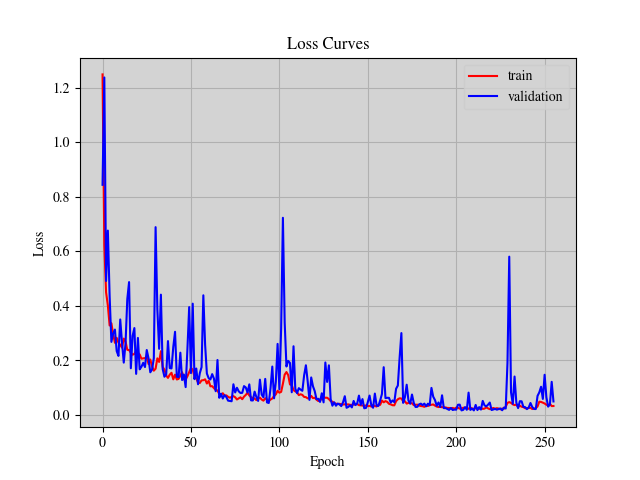

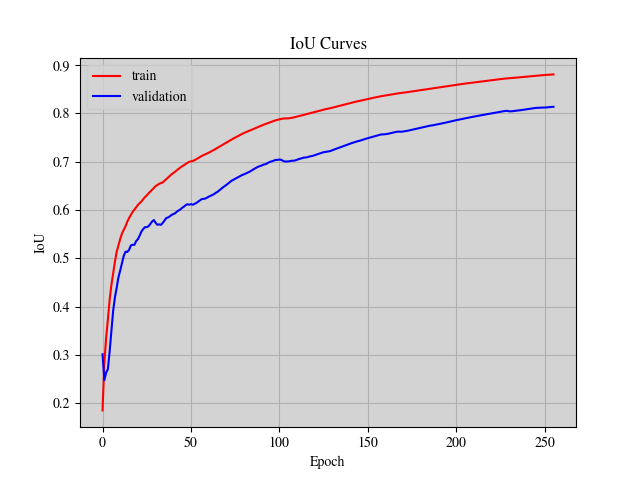

<Figure size 640x480 with 0 Axes>

In [17]:
def _train_loop():
    seed_everything(SEED, workers=True)

    model = ModelWrapper()

    checkpoint = ModelCheckpoint(
        monitor='val_iou',
        dirpath=EXPERIMENT_DIR,
        mode='max',
        filename=f"{MODEL_NAME}_best",
    )
    print(MODEL_NAME)
    early_stopping = EarlyStopping(
        monitor="val_iou",
        min_delta=0.00,
        patience=int(EARLY_STOPPING_PATIENCE * EPOCH),
        verbose=False,
        mode="max",
    )

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=[checkpoint, early_stopping],
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [18]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = ModelWrapper()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/PointNet_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/PointNet_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/PointNet_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at exp

Dataset split: test
Size: 47


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │     0.885283350944519     │
│         test_loss         │    0.16901186108589172    │
└───────────────────────────┴───────────────────────────┘

## **Inference**

### **Utils**

In [19]:
def visualize_data(point_cloud, labels):

    labels = np.array(labels)
    idx = np.where(labels != "none")[0]

    df = pd.DataFrame(
        data={
            "x": point_cloud[idx, 0],
            "y": point_cloud[idx, 1],
            "z": point_cloud[idx, 2],
            "label": labels[idx],
        }
    )

    fig = px.scatter_3d(
        df,
        x="x",
        y="y",
        z="z",
        opacity=0.3,
        color="label",
    )
    fig.show()

    fig.write_html("experiment/result.html")

### **Initialization**

In [20]:
model = ModelWrapper.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

ModelWrapper(
  (arch): PointNet(
    (stn): TNet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, ker

### **Visualization**

In [21]:
InferenceDataset = copy.deepcopy(ShapeNetDataset("inference"))
point_cloud = InferenceDataset.inference_point_cloud
trainer = Trainer()
label_cloud = trainer.predict(
    model=model,
    dataloaders=data.DataLoader(
        dataset=InferenceDataset,
        batch_size=1,
        shuffle=False,
    ),
)[0].data.cpu().numpy()
label_map = ShapeNetDataset.labels + ["none"]

Dataset split: inference


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Size: 103


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [22]:
visualize_data(
    point_cloud,
    [
        label_map[np.argmax(label)] for label in label_cloud[0]
    ],
)